In [7]:
%load_ext autoreload
%autoreload 2
import numpy as np
import matplotlib.pyplot as plt
from configs import project_config
from configs.RecursiveVPSDE.LSTM_fMullerBrown.recursive_LSTM_PostMeanScore_MullerBrown_T256_H05_tl_110data import \
    get_config

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
config = get_config()
deltaT = config.deltaT
print(config.loss_factor)

2


1.4269866298276357 0.02357788980116271 inf


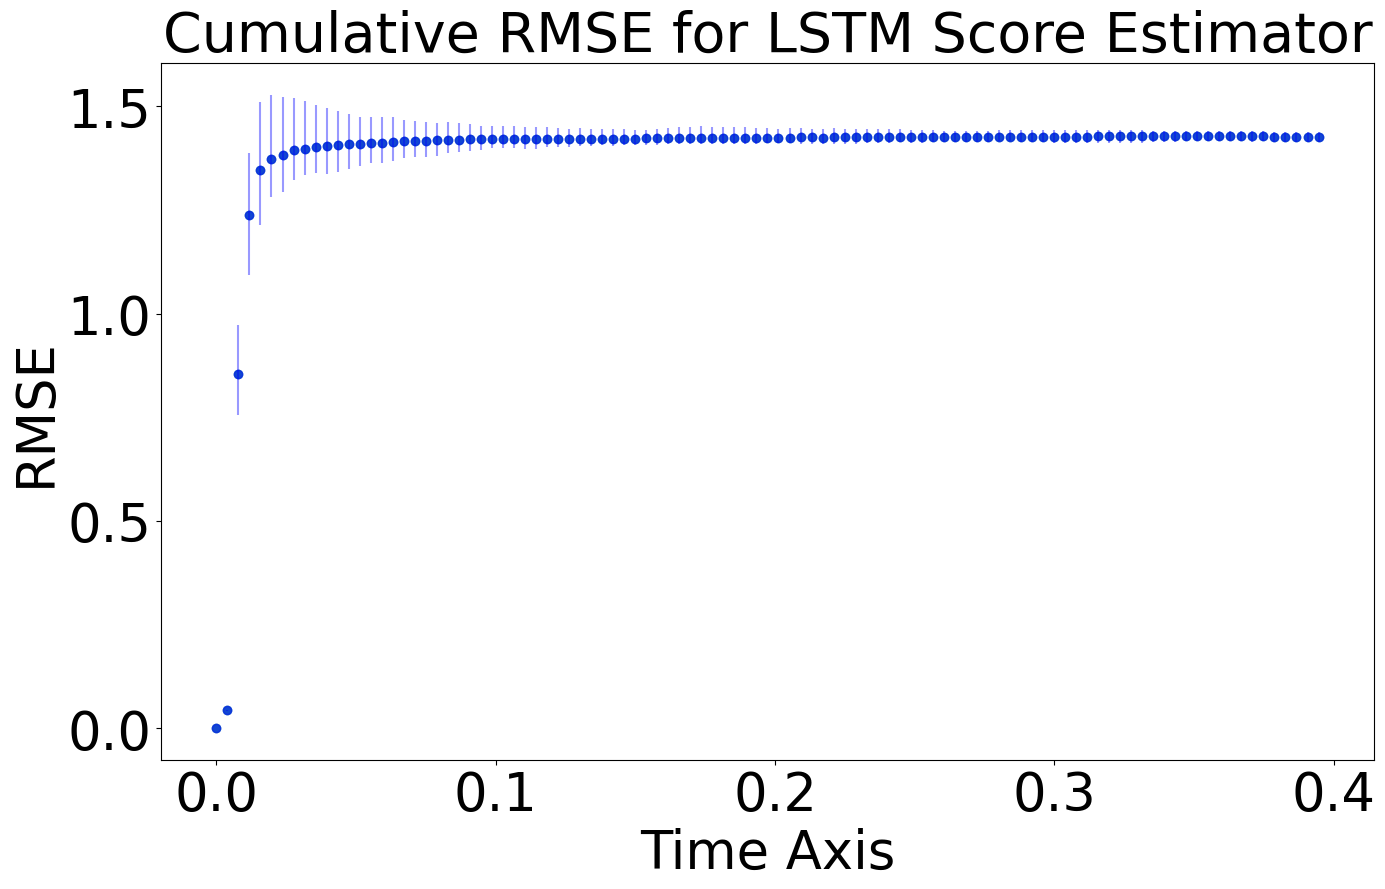

Final time cumulative RMSE local-time error 1.4269866298276357 with final IQR (1.4144835096489174, 1.4380613994500802) at Nepoch 60

1.4150317321735018 0.025746728649318262 1.4269866298276357


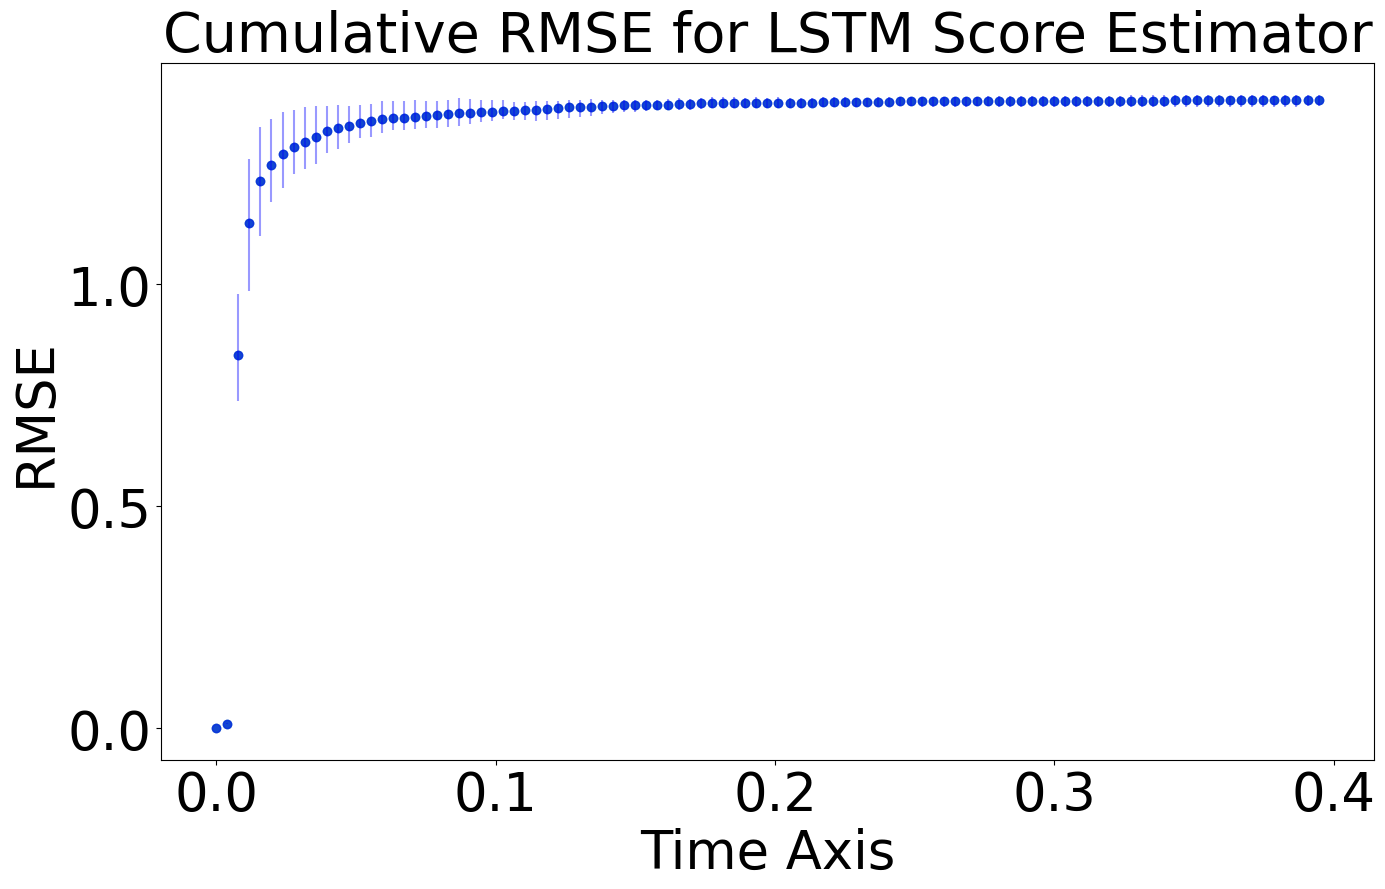

Final time cumulative RMSE local-time error 1.4150317321735018 with final IQR (1.4006653049262532, 1.4264120335755714) at Nepoch 100

1.4052400162214427 0.02478978194495829 1.4150317321735018


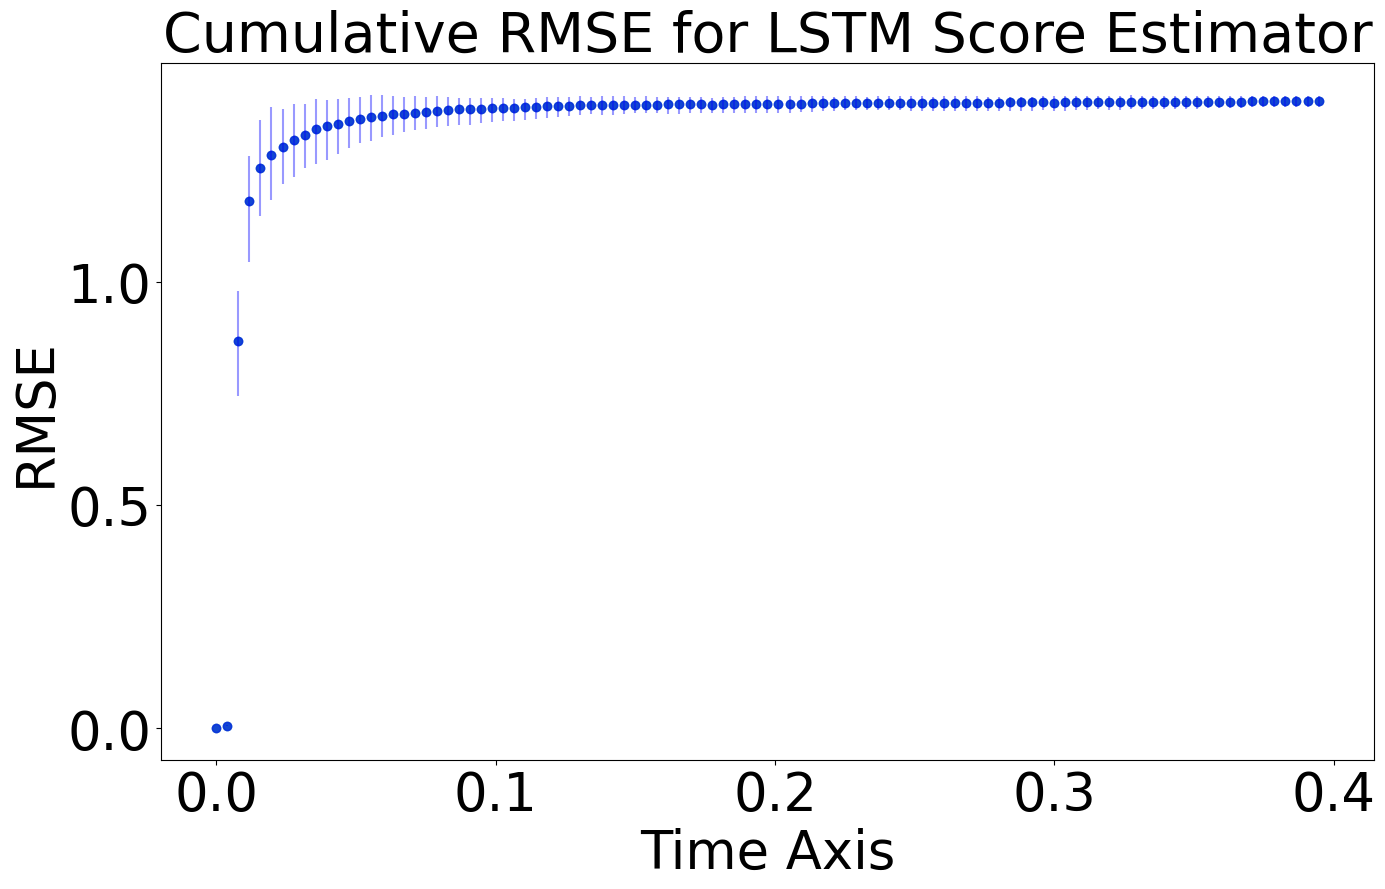

Final time cumulative RMSE local-time error 1.4052400162214427 with final IQR (1.3915026410929563, 1.4162924230379146) at Nepoch 150

1.386163310173074 0.026278248570932305 1.4052400162214427


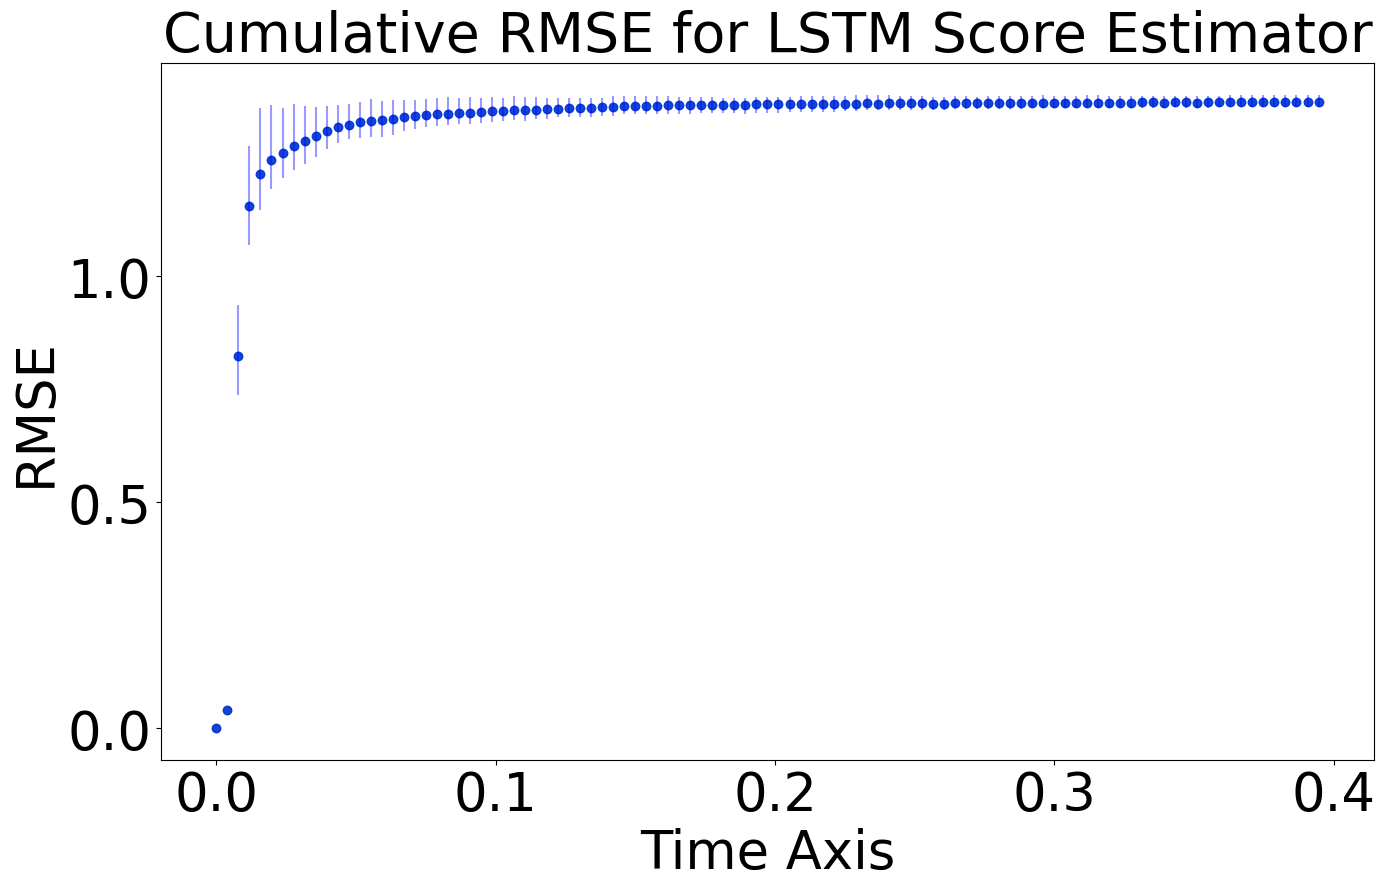

Final time cumulative RMSE local-time error 1.386163310173074 with final IQR (1.375110326765741, 1.4013885753366733) at Nepoch 300

1.1407768445287938 0.024459858594103823 1.386163310173074


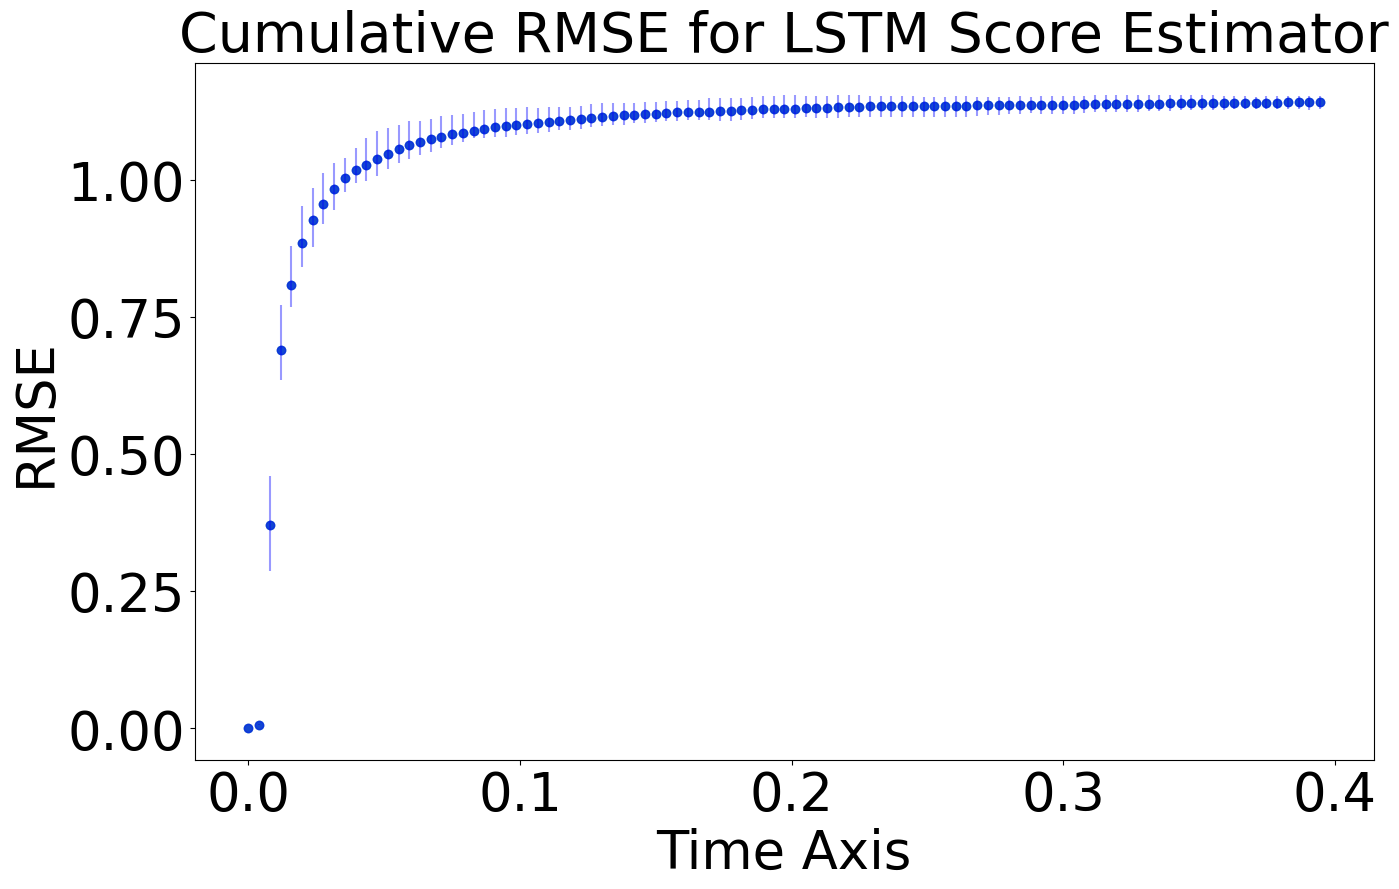

Final time cumulative RMSE local-time error 1.1407768445287938 with final IQR (1.128003771354219, 1.1524636299483229) at Nepoch 960

1.165153658145008 0.02420599023937764 1.1407768445287938
1.1486175019120428 0.029081389215613873 1.1407768445287938
1.1688104924482539 0.022486357149844816 1.1407768445287938
1.1960849940236786 0.018376814627551807 1.1407768445287938
1.1994097432714 0.03520631422404974 1.1407768445287938
1.2184171651032936 0.029675330835249092 1.1407768445287938
1.499298761971683 0.04825996030197666 1.1407768445287938


In [9]:
curr_rmse = np.inf
toSave = True
for Nepoch in config.max_epochs:
    try:
        num_diff_times = 1
        save_path = (project_config.ROOT_DIR + f"experiments/results/TSPM_LSTM_fMullerBrown_OOSDriftTrack_{Nepoch}Nep_{config.t0}t0_{config.deltaT:.3e}dT_{config.residual_layers}ResLay_{config.loss_factor}LFac").replace(
            ".", "")
        all_true_states = np.load(save_path + "_global_true_states.npy")/np.sqrt(config.deltaT)
        all_local_states= np.load(save_path + "_local_states.npy")/np.sqrt(config.deltaT)
        all_local_errors = np.cumsum(np.mean(np.power(all_true_states- all_local_states,2), axis=(1,3)), axis=-1)/np.arange(1, all_local_states.shape[2]+1)
        total_local_errors = np.mean(np.sqrt(all_local_errors), axis=0)
        total_local_errors_minq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.025)
        total_local_errors_maxq = np.quantile(np.sqrt(all_local_errors), axis=0,q=0.975)
        print(total_local_errors[-1], total_local_errors_maxq[-1]-total_local_errors_minq[-1], curr_rmse)
        if total_local_errors[-1]  < curr_rmse:
            time_steps = np.linspace(config.t0,config.deltaT*total_local_errors.shape[0],total_local_errors.shape[0])
            curr_rmse = total_local_errors[-1] #- total_local_errors_minq[-1]
            fig, ax = plt.subplots(figsize=(14,9))
            ax.scatter(time_steps, total_local_errors)
            #plt.fill_between(time_steps, total_local_errors_minq, total_local_errors_maxq, color="blue", alpha=0.2, label="95% Confidence Band")
            plt.errorbar(time_steps,total_local_errors,yerr=[total_local_errors-total_local_errors_minq, total_local_errors_maxq-total_local_errors],xerr=None, fmt='o', color="blue", alpha=0.4)

            ax.set_title(f"Cumulative RMSE for LSTM Score Estimator",fontsize=40)
            ax.set_ylabel("RMSE", fontsize=38)
            ax.set_xlabel("Time Axis", fontsize=38)
            ax.tick_params(labelsize=38)
            plt.tight_layout()
            if toSave:
                plt.savefig((f"/Users/marcos/Library/CloudStorage/OneDrive-ImperialCollegeLondon/StatML_CDT/Year2/DiffusionModelPresentationImages/fMullerBrown_OOSDriftTrack_{Nepoch}Nep_PM_LSTM").replace(".", "")+".png")
            plt.show()
            plt.close()
            print(f"Final time cumulative RMSE local-time error {total_local_errors[-1]} with final IQR {total_local_errors_minq[-1],total_local_errors_maxq[-1]} at Nepoch {Nepoch}\n")
    except FileNotFoundError as e:
        continue